In [ ]:
import os
import anndata as ad
import torch
import numpy
import argparse
import pandas as pd
import scanpy as sc
from tqdm.auto import tqdm

os.getcwd()

In [ ]:
# TASK = 'GEX2ADT'
TASK = 'GEX2ATAC'
DATASET_PATH = "datasets"
PRETRAIN_PATH = "pretrain"
PREDICTION_PATH = "pretrain/defaultGEX2ATAC.h5ad"
OUT_NAME = ""

if TASK == 'GEX2ADT':
    is_multiome = False
    test_path = os.path.join(DATASET_PATH, "openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna"
                                                ".censor_dataset.output_")
    completedata_path = os.path.join(DATASET_PATH, "post_competition/openproblems_bmmc_cite_complete.h5ad")
    pretrain_path = os.path.join(PRETRAIN_PATH, "GEX2ADT")
elif TASK == 'GEX2ATAC':
    is_multiome = True
    test_path = os.path.join(DATASET_PATH, "openproblems_bmmc_multiome_phase2_rna"
                                                "/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_")
    completedata_path = os.path.join(DATASET_PATH, "post_competition/openproblems_bmmc_multiome_complete.h5ad")
    pretrain_path = os.path.join(PRETRAIN_PATH, "GEX2ATAC")
else:
    raise ValueError('Unknown task: ' + TASK)

par = {
        "input_train_mod1": f"{test_path}train_mod1.h5ad",
        "input_train_mod2": f"{test_path}train_mod2.h5ad",
        "input_test_mod1": f"{test_path}test_mod1.h5ad",
        "input_test_mod2": f"{test_path}test_mod2.h5ad",
        "input_complete": completedata_path,
        "input_test_sol": f"{test_path}test_sol.h5ad",
        "input_test_prediction": PREDICTION_PATH,
        "input_pretrain": pretrain_path,
        "output": os.path.join(PRETRAIN_PATH, OUT_NAME + TASK)
}

In [10]:
sc.pp.neighbors(input_train_mod1)
sc.tl.umap(input_train_mod1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


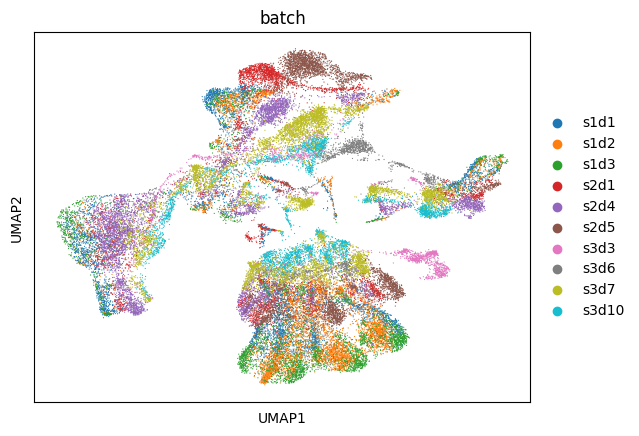

In [12]:
# sc.pl.umap(input_train_mod1, color='cell_type')
sc.pl.umap(input_train_mod1, color='batch')

In [4]:
input_complete = ad.read_h5ad(par["input_complete"])

In [5]:
input_complete

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [26]:
input_atac_umap = input_complete.copy()
input_atac_umap.obsm["umap"] = input_complete.obsm["ATAC_umap"]

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


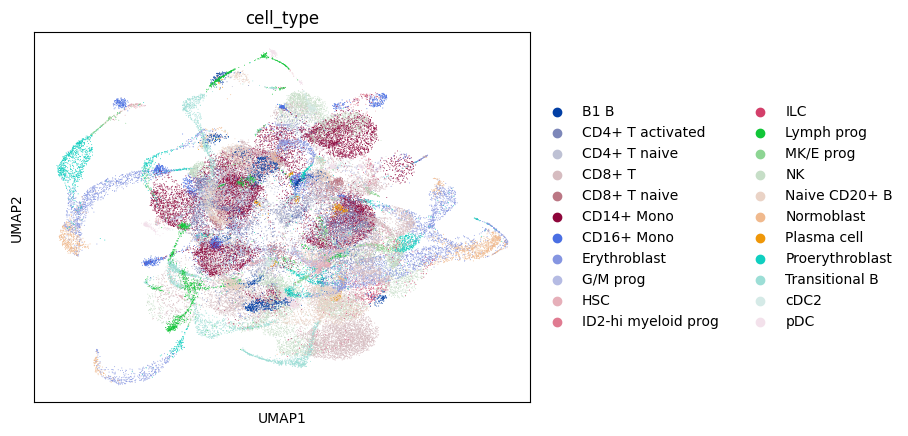

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


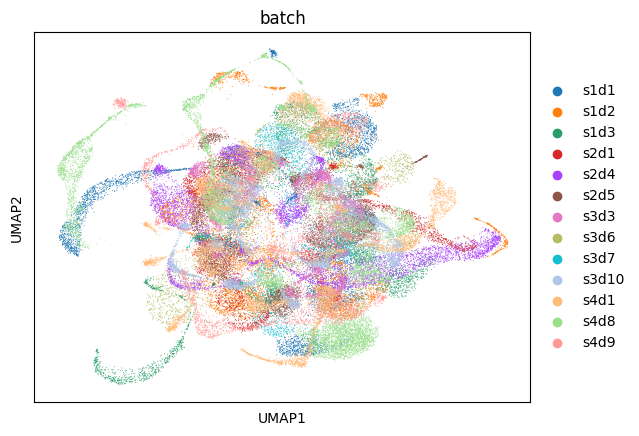

In [27]:
sc.pl.umap(input_atac_umap, color='cell_type')
sc.pl.umap(input_atac_umap, color='batch')

In [7]:
input_gex_umap = input_complete.copy()
input_gex_umap.obsm["X_umap"] = input_complete.obsm["GEX_X_umap"]

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


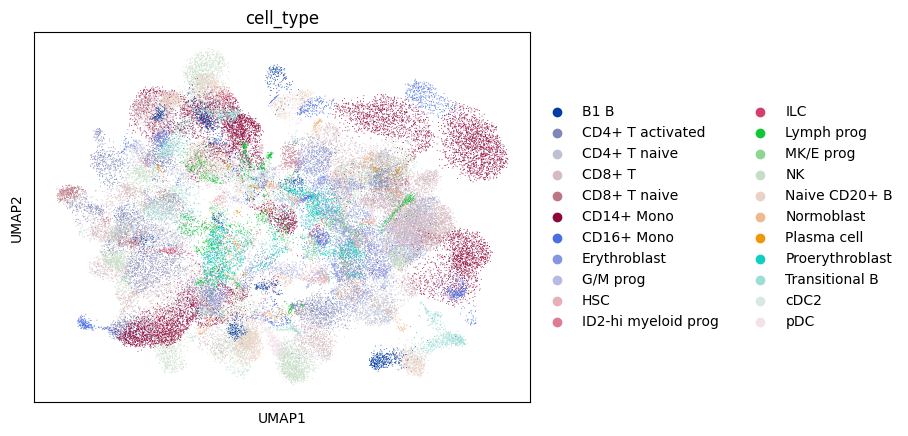

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


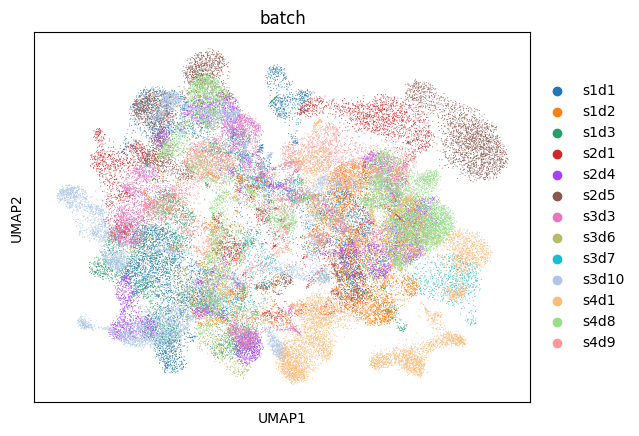

In [8]:
sc.pl.umap(input_gex_umap, color='cell_type')
sc.pl.umap(input_gex_umap, color='batch')

In [21]:
input_atac_umap.obsm["umap"]

array([[-2.99695394, -1.46148732],
       [ 3.62082222,  8.49412027],
       [ 4.21865776, -4.65188774],
       ...,
       [ 1.51918961,  3.29149001],
       [-3.6700462 ,  0.78682714],
       [ 4.1587366 , -6.14877231]])

In [22]:
input_gex_umap.obsm["X_umap"]

array([[ 7.16211  , 13.8464155],
       [-3.701953 , 12.805775 ],
       [-0.5139551,  1.1795509],
       ...,
       [10.407891 ,  8.894352 ],
       [ 6.8192625,  5.207611 ],
       [ 1.7428216,  8.992124 ]], dtype=float32)

# UMAP on train data

In [2]:
import argparse
import os
import pickle
import sys

import anndata as ad
import numpy as np
import pandas as pd
import scipy.sparse
import torch
from distutils.util import strtobool

sys.path.append(".")
from resources.data import ModalityMatchingDataset
from resources.models import Modality_CLIP, Encoder
from resources.postprocessing import OT_matching, MWB_matching
from resources.hyperparameters import *
from resources.preprocessing import harmony
from evaluate import evaluate

In [4]:
# Load data
# input_train_mod1 = ad.read_h5ad(par["input_train_mod1"])
# input_train_mod2 = ad.read_h5ad(par["input_train_mod2"])
input_test_mod1 = ad.read_h5ad(par["input_test_mod1"])
input_test_mod2 = ad.read_h5ad(par["input_test_mod2"])
input_complete = ad.read_h5ad(par["input_complete"])

In [15]:
input_train_mod2.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '42482', '42483', '42484', '42485', '42486', '42487', '42488', '42489',
       '42490', '42491'],
      dtype='object', length=42492)

In [89]:
# test_withcelltype = input_complete[input_test_mod1.obs_names]
test_withcelltype_mod1 = ad.read_h5ad("datasets/PBMC/glue_processed/test_mod1.h5ad")
test_withcelltype_mod2 = ad.read_h5ad("datasets/PBMC/glue_processed/test_mod2.h5ad")

In [38]:
# load hard_x.npy
with open("run/hard_X.npy", "rb") as f:
    hard_X = np.load(f)

In [39]:
mod2_permutation = hard_X.argmax(axis=1)

In [42]:
mod2_permutation

array([   0, 8212, 3801, ..., 6871, 7749, 8250])

In [84]:
test_withcelltype_mod2.X = test_withcelltype_mod2.X.toarray()[mod2_permutation]

In [80]:
test_withcelltype_mod2.obs_names

Index(['AAACAGCCAATCCCTT-1', 'AAACAGCCAATGCGCT-1', 'AAACAGCCACCAACCG-1',
       'AAACAGCCAGGATAAC-1', 'AAACAGCCAGTTTACG-1', 'AAACAGCCATCCAGGT-1',
       'AAACATGCAAGGTCCT-1', 'AAACATGCACCGGCTA-1', 'AAACATGCACTTGTTC-1',
       'AAACATGCAGCAAGTG-1',
       ...
       'TTTGTGTTCGATAACC-1', 'TTTGTGTTCGGGACCT-1', 'TTTGTGTTCGTCAAGT-1',
       'TTTGTGTTCTCCATAT-1', 'TTTGTTGGTCAGGAAG-1', 'TTTGTTGGTGACATGC-1',
       'TTTGTTGGTGTTAAAC-1', 'TTTGTTGGTTAGGATT-1', 'TTTGTTGGTTGGTTAG-1',
       'TTTGTTGGTTTGCAGA-1'],
      dtype='object', name='cells', length=9631)

In [85]:
test_withcelltype_mod2.X[1].sum() # 15072.235 with no permutation

16861.63

In [27]:
test_withcelltype_mod2.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 9631 × 116490
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'>

In [105]:
# concatenate the two modalities along axis 1
test_withcelltype = ad.concat([test_withcelltype_mod1, test_withcelltype_mod2], axis=1, keys=['GEX', 'ATAC'], merge='first', uns_merge='first')
test_withcelltype

AnnData object with n_obs × n_vars = 9631 × 129921
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'

In [29]:
test_withcelltype.obs["cell_type"]

cells
AAACAGCCAATCCCTT-1      CD4 TCM
AAACAGCCAATGCGCT-1    CD4 Naive
AAACAGCCACCAACCG-1    CD8 Naive
AAACAGCCAGGATAAC-1    CD4 Naive
AAACAGCCAGTTTACG-1      CD4 TCM
                        ...    
TTTGTTGGTGACATGC-1    CD8 Naive
TTTGTTGGTGTTAAAC-1    CD8 Naive
TTTGTTGGTTAGGATT-1           NK
TTTGTTGGTTGGTTAG-1      CD4 TCM
TTTGTTGGTTTGCAGA-1    CD8 TEM_1
Name: cell_type, Length: 9631, dtype: category
Categories (19, object): ['CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', ..., 'Treg', 'cDC', 'gdT', 'pDC']

In [14]:
test_withcelltype.var_names

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'NOC2L', 'KLHL17', 'ISG15',
       'C1orf159', 'SDF4', 'B3GALT6', 'UBE2J2',
       ...
       '116480', '116481', '116482', '116483', '116484', '116485', '116486',
       '116487', '116488', '116489'],
      dtype='object', length=129921)

In [31]:
test_withcelltype.obs["cell_type"].to_frame().value_counts()

cell_type     
CD14 Mono         2554
CD4 Naive         1382
CD8 Naive         1354
CD4 TCM           1113
CD16 Mono          442
NK                 403
CD8 TEM_1          322
CD8 TEM_2          315
Intermediate B     300
Memory B           298
CD4 TEM            286
cDC                180
Treg               157
gdT                143
MAIT               130
Naive B            125
pDC                 98
HSPC                17
Plasma              12
dtype: int64

In [30]:
test_withcelltype.var["feature_types"]

KeyError: 'feature_types'

In [106]:
def umap(adata, save_celltype='umap_celltype.pdf', save_batch='umap_batch.pdf'):
    sc.pp.neighbors(adata)
    sc.tl.umap(adata, random_state=0)
    sc.pl.umap(adata, color='cell_type', edges=False, save=save_celltype)
    sc.pl.umap(adata, color='batch', edges=False, save=save_batch)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


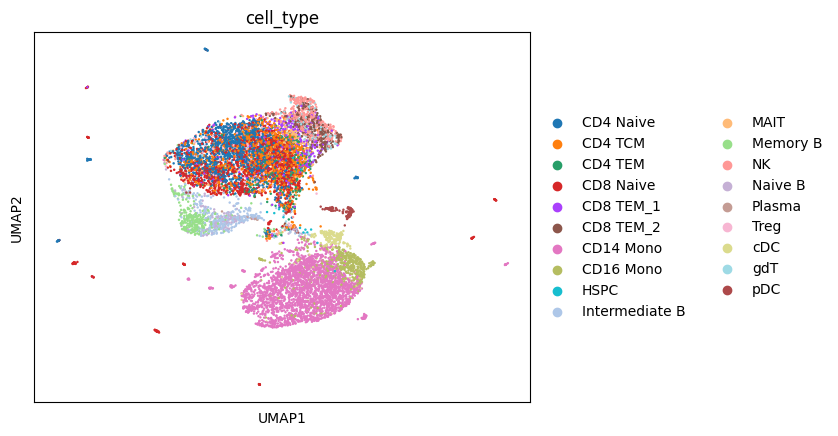

KeyError: 'Could not find key batch in .var_names or .obs.columns.'

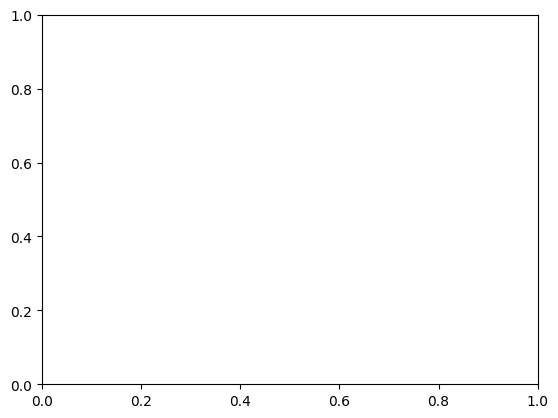

In [87]:
umap(test_withcelltype, save_celltype="pbmc_predicted_match.pdf")

In [107]:
# UMAP of embedding concatenations
import torch
fold = 0
# emb_mod12 = torch.load("pretrain/defaultPredictedMatch" + TASK + "emb_mod12_" + str(fold) + ".pt")
emb_mod12 = torch.load("pretrain/pbmc1NoEGEX2ATACemb_mod12_fold0_predmatch.pt")
test_withcelltype.obsm["X_pca"] = emb_mod12


/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


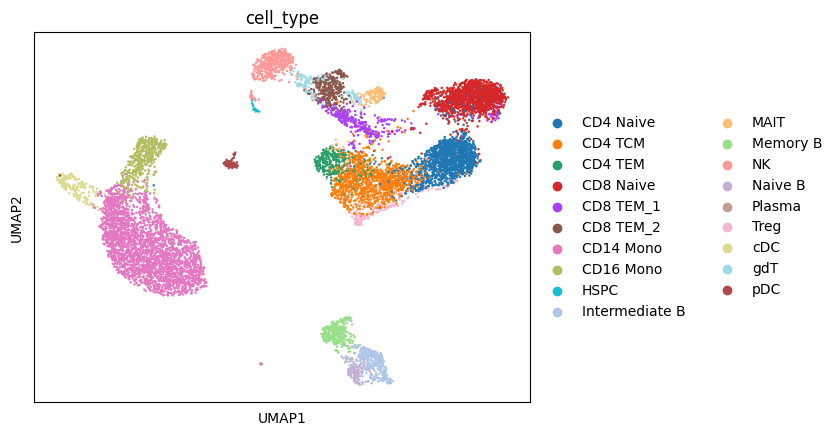

KeyError: 'Could not find key batch in .var_names or .obs.columns.'

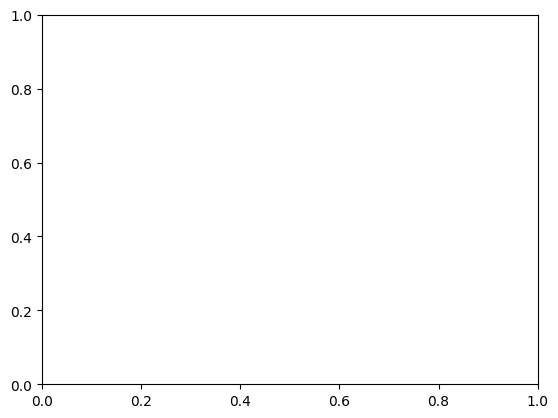

In [108]:
umap(test_withcelltype, save_batch="randmatch_test_atacgex_emb_batch_umap.pdf", save_celltype="pbmc_emb_predmatch_noentropy.pdf")

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


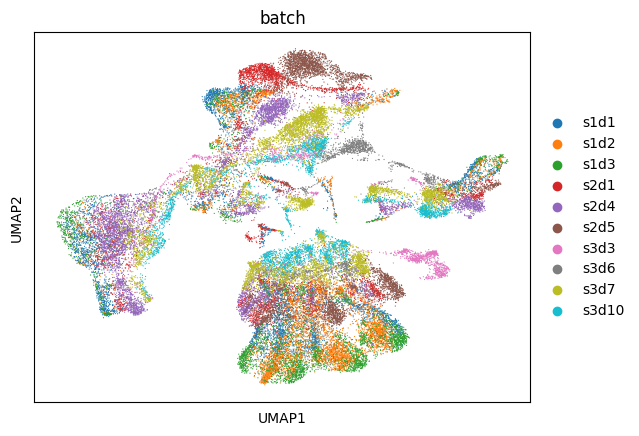

In [18]:
# umap of train mod1
sc.pp.neighbors(input_train_mod1)
sc.tl.umap(input_train_mod1)
# sc.pl.umap(input_train_mod1, color='cell_type')
sc.pl.umap(input_train_mod1, color='batch')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


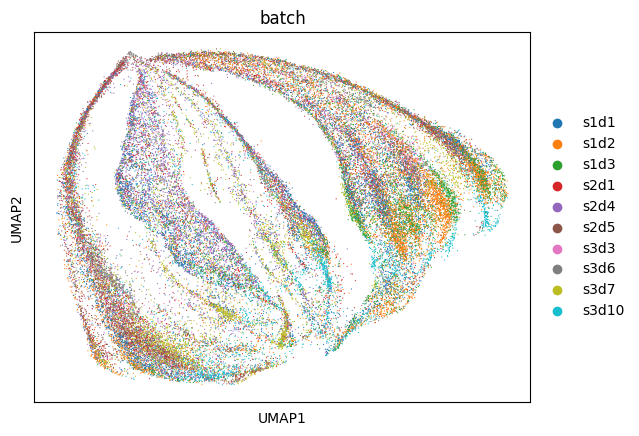

In [40]:
# umap of train mod2
sc.pp.neighbors(input_train_mod2)
sc.tl.umap(input_train_mod2)
# sc.pl.umap(input_train_mod1, color='cell_type')
sc.pl.umap(input_train_mod2, color='batch')

In [7]:
# Load and apply LSI transformation
with open(par["input_pretrain"] + "/lsi_GEX_transformer.pickle", "rb") as f:
    lsi_transformer_gex = pickle.load(f)
if is_multiome:
    with open(par["input_pretrain"] + "/lsi_ATAC_transformer.pickle", "rb") as f:
        lsi_transformer_atac = pickle.load(f)
    gex_train = lsi_transformer_gex.transform(input_train_mod1)
    gex_test = lsi_transformer_gex.transform(input_test_mod1)
    mod2_train = lsi_transformer_atac.transform(input_train_mod2)
    mod2_test = lsi_transformer_atac.transform(input_test_mod2)
else:
    gex_train = lsi_transformer_gex.transform(input_train_mod1)
    gex_test = lsi_transformer_gex.transform(input_test_mod1)
    mod2_train = input_train_mod2.to_df()
    mod2_test = input_test_mod2.to_df()

In [8]:
TASK

'GEX2ATAC'

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define argument parsers
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(dest='TASK')

# Common args
for key, value in defaults_common.items():
    parser.add_argument("--" + key, default=value,
                        type=(lambda x: bool(strtobool(x))) if type(value) == bool else type(value))

# GEX2ADT args
parser_GEX2ADT = subparsers.add_parser('GEX2ADT', help='train GEX2ADT model')
for key, value in defaults_GEX2ADT.items():
    parser_GEX2ADT.add_argument("--" + key, default=value, type=type(value))

# GEX2ATAC args
parser_GEX2ATAC = subparsers.add_parser('GEX2ATAC', help='train GEX2ATAC model')
for key, value in defaults_GEX2ATAC.items():
    parser_GEX2ATAC.add_argument("--" + key, default=value, type=type(value))

# Parse args
args, unknown_args = parser.parse_known_args([TASK])
print("args:", args, "unknown_args:", unknown_args)

Using device: cuda
args: Namespace(BATCH_LABEL_MATCHING=True, BATCH_SIZE=16384, DATASETS_PATH='datasets', DROPOUT_RATES_ATAC=0.67, DROPOUT_RATES_GEX0=0.34, DROPOUT_RATES_GEX1=0.47, EMBEDDING_DIM=128, HARMONY=True, HYPERPARAMS=True, LAYERS_DIM_ATAC=2048, LAYERS_DIM_GEX0=2048, LAYERS_DIM_GEX1=1024, LOG_T=2.74, LR=0.0006, N_EPOCHS=7000, N_LSI_COMPONENTS_ATAC=256, N_LSI_COMPONENTS_GEX=192, OT_ENTROPY=0.01, OT_MATCHING=True, OUT_NAME='', PRETRAIN_PATH='pretrain', SCORES_PATH='scores', SFA_NOISE=0.0, TASK='GEX2ATAC', TRANSDUCTIVE=True, VALID_FOLD=0, WEIGHT_DECAY=0.000125) unknown_args: []


In [12]:
fold = 0
weight_file = par["input_pretrain"] + "/" + str(fold) + "/model.best.pth"
if os.path.exists(weight_file):
    print("Loading weights from " + weight_file)
    weight = torch.load(weight_file, map_location="cpu")

    # Define modality encoders
    if is_multiome:
        model = Modality_CLIP(
            Encoder=Encoder,
            layers_dims=(
                [args.LAYERS_DIM_ATAC],
                [args.LAYERS_DIM_GEX0, args.LAYERS_DIM_GEX1],
            ),
            dropout_rates=(
                [args.DROPOUT_RATES_ATAC],
                [args.DROPOUT_RATES_GEX0, args.DROPOUT_RATES_GEX1],
            ),
            dim_mod1=args.N_LSI_COMPONENTS_ATAC,
            dim_mod2=args.N_LSI_COMPONENTS_GEX,
            output_dim=args.EMBEDDING_DIM,
            T=args.LOG_T,
            noise_amount=args.SFA_NOISE,
        ).to(device)
    else:
        model = Modality_CLIP(
            Encoder=Encoder,
            layers_dims=(
                [args.LAYERS_DIM_ADT0, args.LAYERS_DIM_ADT1],
                [args.LAYERS_DIM_GEX0, args.LAYERS_DIM_GEX1],
            ),
            dropout_rates=(
                [args.DROPOUT_RATES_ADT0, args.DROPOUT_RATES_ADT1],
                [args.DROPOUT_RATES_GEX0, args.DROPOUT_RATES_GEX1],
            ),
            dim_mod1=args.N_LSI_COMPONENTS_ADT,
            dim_mod2=args.N_LSI_COMPONENTS_GEX,
            output_dim=args.EMBEDDING_DIM,
            T=args.LOG_T,
            noise_amount=args.SFA_NOISE,
        ).to(device)

    # Load pretrained weights
    model.load_state_dict(weight)

    # Load torch datasets
    dataset_train = ModalityMatchingDataset(pd.DataFrame(gex_train), pd.DataFrame(mod2_train))
    dataset_test = ModalityMatchingDataset(pd.DataFrame(gex_test), pd.DataFrame(mod2_test))
    data_train = torch.utils.data.DataLoader(dataset_train, 32, shuffle=False)
    data_test = torch.utils.data.DataLoader(dataset_test, 32, shuffle=False)

    # Predict on train set
    all_emb_mod1_train = []
    all_emb_mod2_train = []
    indexes = []
    model.eval()
    for batch in tqdm(data_train):
        x1 = batch["features_first"].float()
        x2 = batch["features_second"].float()
        # The model applies the GEX encoder to the second argument, here x1
        logits, features_mod2, features_mod1 = model(
            x2.to(device), x1.to(device)
        )

        all_emb_mod1_train.append(features_mod1.detach().cpu())
        all_emb_mod2_train.append(features_mod2.detach().cpu())

    all_emb_mod1_train = torch.cat(all_emb_mod1_train)
    all_emb_mod2_train = torch.cat(all_emb_mod2_train)

    # Predict on test set
    all_emb_mod1 = []
    all_emb_mod2 = []
    indexes = []
    model.eval()
    for batch in data_test:
        x1 = batch["features_first"].float()
        x2 = batch["features_second"].float()
        # The model applies the GEX encoder to the second argument, here x1
        logits, features_mod2, features_mod1 = model(
            x2.to(device), x1.to(device)
        )

        all_emb_mod1.append(features_mod1.detach().cpu())
        all_emb_mod2.append(features_mod2.detach().cpu())

    all_emb_mod1 = torch.cat(all_emb_mod1)
    all_emb_mod2 = torch.cat(all_emb_mod2)


Loading weights from pretrain/GEX2ATAC/0/model.best.pth
dropout list [Dropout(p=0.67, inplace=False)]
SFA with noise: 0.0
dropout list [Dropout(p=0.34, inplace=False), Dropout(p=0.47, inplace=False)]
SFA with noise: 0.0


  0%|          | 0/1328 [00:00<?, ?it/s]

In [16]:
# all_emb_mod1_train = torch.cat(all_emb_mod1_train)
# all_emb_mod2_train = torch.cat(all_emb_mod2_train)
all_emb_mod2_train.shape

torch.Size([42492, 128])

In [15]:
all_emb_mod1_train.shape

torch.Size([42492, 128])

In [30]:
input_train_mod1

AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [36]:
# reload from file to delete umap coordinates
input_train_mod1_emb = ad.read_h5ad(par["input_train_mod1"])

In [37]:
input_train_mod1_emb.obsm["X_pca"] = all_emb_mod1_train

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


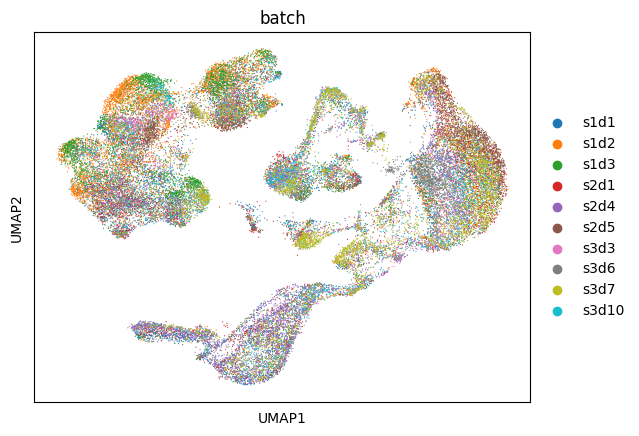

In [39]:
# umap of train mod1 embeddings
sc.pp.neighbors(input_train_mod1_emb)
sc.tl.umap(input_train_mod1_emb)
# sc.pl.umap(input_train_mod1, color='cell_type')
sc.pl.umap(input_train_mod1_emb, color='batch')

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


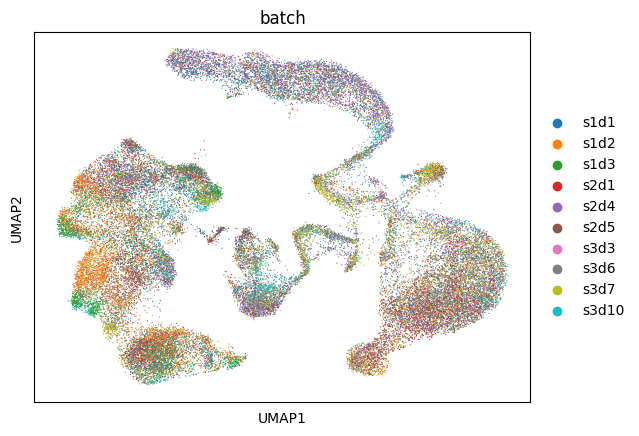

In [17]:
# reload from file to delete umap coordinates
input_train_mod2_emb = ad.read_h5ad(par["input_train_mod2"])
input_train_mod2_emb.obsm["X_pca"] = all_emb_mod2_train
# umap of train mod1 embeddings
sc.pp.neighbors(input_train_mod2_emb)
sc.tl.umap(input_train_mod2_emb)
# sc.pl.umap(input_train_mod1, color='cell_type')
sc.pl.umap(input_train_mod2_emb, color='batch')

In [18]:
# reload from file to delete umap coordinates
input_train_mod1_emb = ad.read_h5ad(par["input_train_mod1"])
input_train_mod2_emb = ad.read_h5ad(par["input_train_mod2"])
input_train_mod1_emb.obsm["X_pca"] = all_emb_mod1_train
input_train_mod2_emb.obsm["X_pca"] = all_emb_mod2_train
# concatenate to have the same umap space
input_train_mod1mod2_emb = ad.concat((input_train_mod1_emb, input_train_mod2_emb), join='outer')


In [21]:
input_train_mod1mod2_emb.obsm["X_pca"].shape

(84984, 128)

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


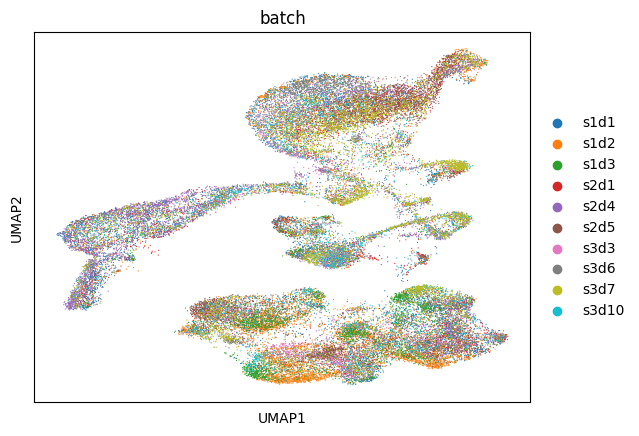

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


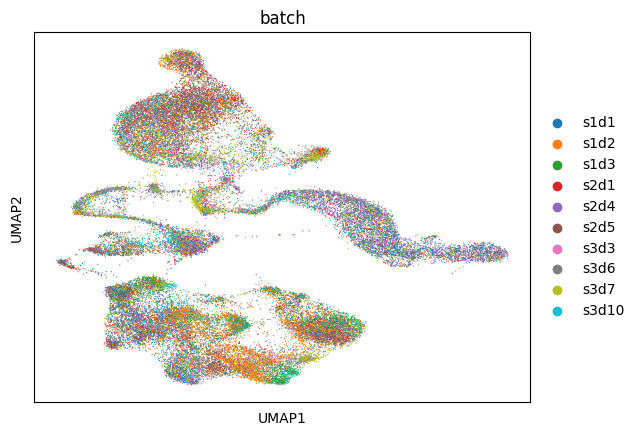

In [19]:
# umap of train mod1mod2 embeddings
sc.pp.neighbors(input_train_mod1mod2_emb)
sc.tl.umap(input_train_mod1mod2_emb)
# sc.pl.umap(input_train_mod1, color='cell_type')
sc.pl.umap(input_train_mod1mod2_emb[:42492], color='batch')
sc.pl.umap(input_train_mod1mod2_emb[42492:], color='batch')

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


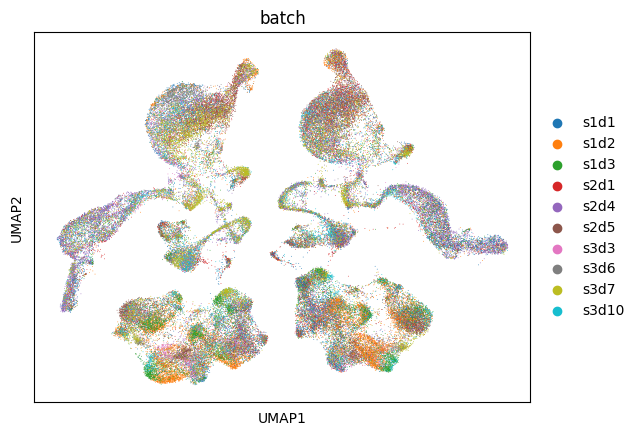

In [22]:
sc.pl.umap(input_train_mod1mod2_emb, color='batch')

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


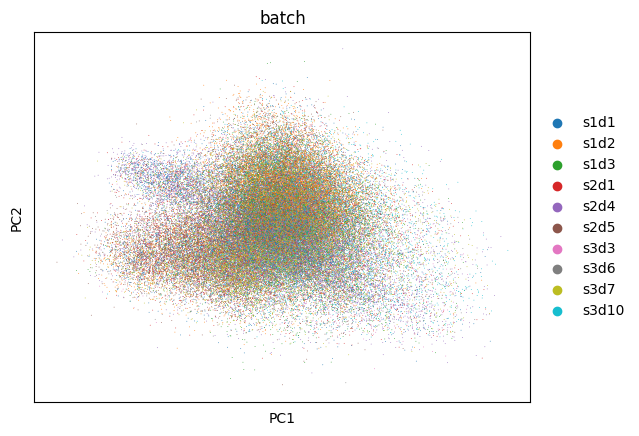

In [23]:
sc.pl.pca(input_train_mod1mod2_emb, color='batch')

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


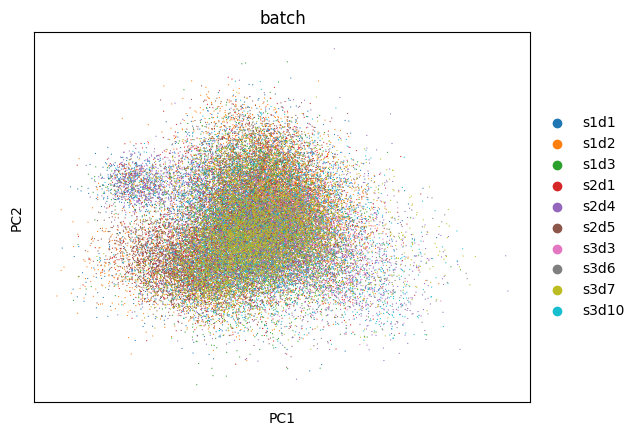

/home/ico/PycharmProjects/SCOOTR/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


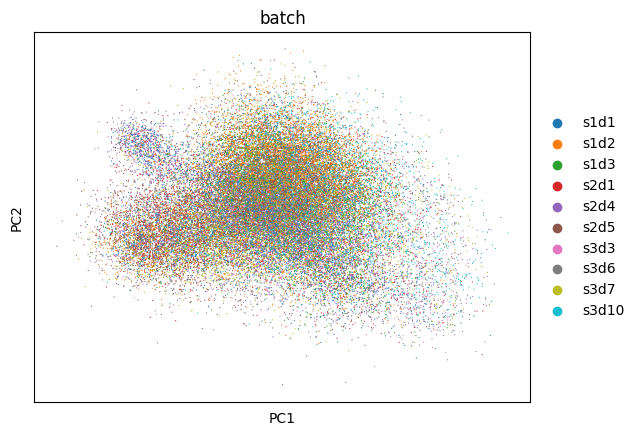

In [24]:
sc.pl.pca(input_train_mod1mod2_emb[:42492], color='batch')
sc.pl.pca(input_train_mod1mod2_emb[42492:], color='batch')